> **Disclaimer**
>
> Please note that although a real-life data set was provided, the business context in this project is fictitious. Any resemblance to companies and persons (living or dead) is coincidental. The course designers and hosts assume no responsibility or liability for any errors or omissions in the content of the business context and data sets. The information in the data sets is provided on an 'as is' basis with no guarantees of completeness, accuracy, usefulness, or timeliness.

# **Detecting the anomalous activity of a ship’s engine**


## **1) Import libraries and dataset**

In [26]:
# Import the necessary libraries.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Setting a standard style for charts
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


# URL to import data set from GitHub.
url = 'https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv'

# Read the CSV file into a new DataFrame.
data = pd.read_csv(url)
data_original = data.copy() # kept it for reference to use later

display(data.head())


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


In [2]:
# Dataset structure and column types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 915.8 KB


## **2) Main statistics of the dataset and EDA**

In [27]:
# Summary statistics of numeric variables
summary_stats = data.describe(percentiles=[.25, .50, .75, .95]).round(2)
display(summary_stats)

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.00,19535.00,19535.00,19535.00,19535.00,19535.00
mean,791.24,3.30,6.66,2.34,77.64,78.43
std,267.61,1.02,2.76,1.04,3.11,6.21
min,61.00,0.00,0.00,0.00,71.32,61.67
25%,593.00,2.52,4.92,1.60,75.73,73.90
50%,746.00,3.16,6.20,2.17,76.82,78.35
75%,934.00,4.06,7.74,2.85,78.07,82.92
95%,1324.00,5.06,12.21,4.44,84.94,88.61
max,2239.00,7.27,21.14,7.48,89.58,195.53


In [ ]:
#CHECK NO NULL DATA
data.isnull().sum()

,0
Engine rpm,0
Lub oil pressure,0
Fuel pressure,0
Coolant pressure,0
lub oil temp,0
Coolant temp,0


In [ ]:
# CHECK FOR DUPLICATE ROWS
duplicate = data[data.duplicated()]

print(f"Number of duplicate rows: {len(duplicate)}")

display(duplicate)

Number of duplicate rows: 0


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp


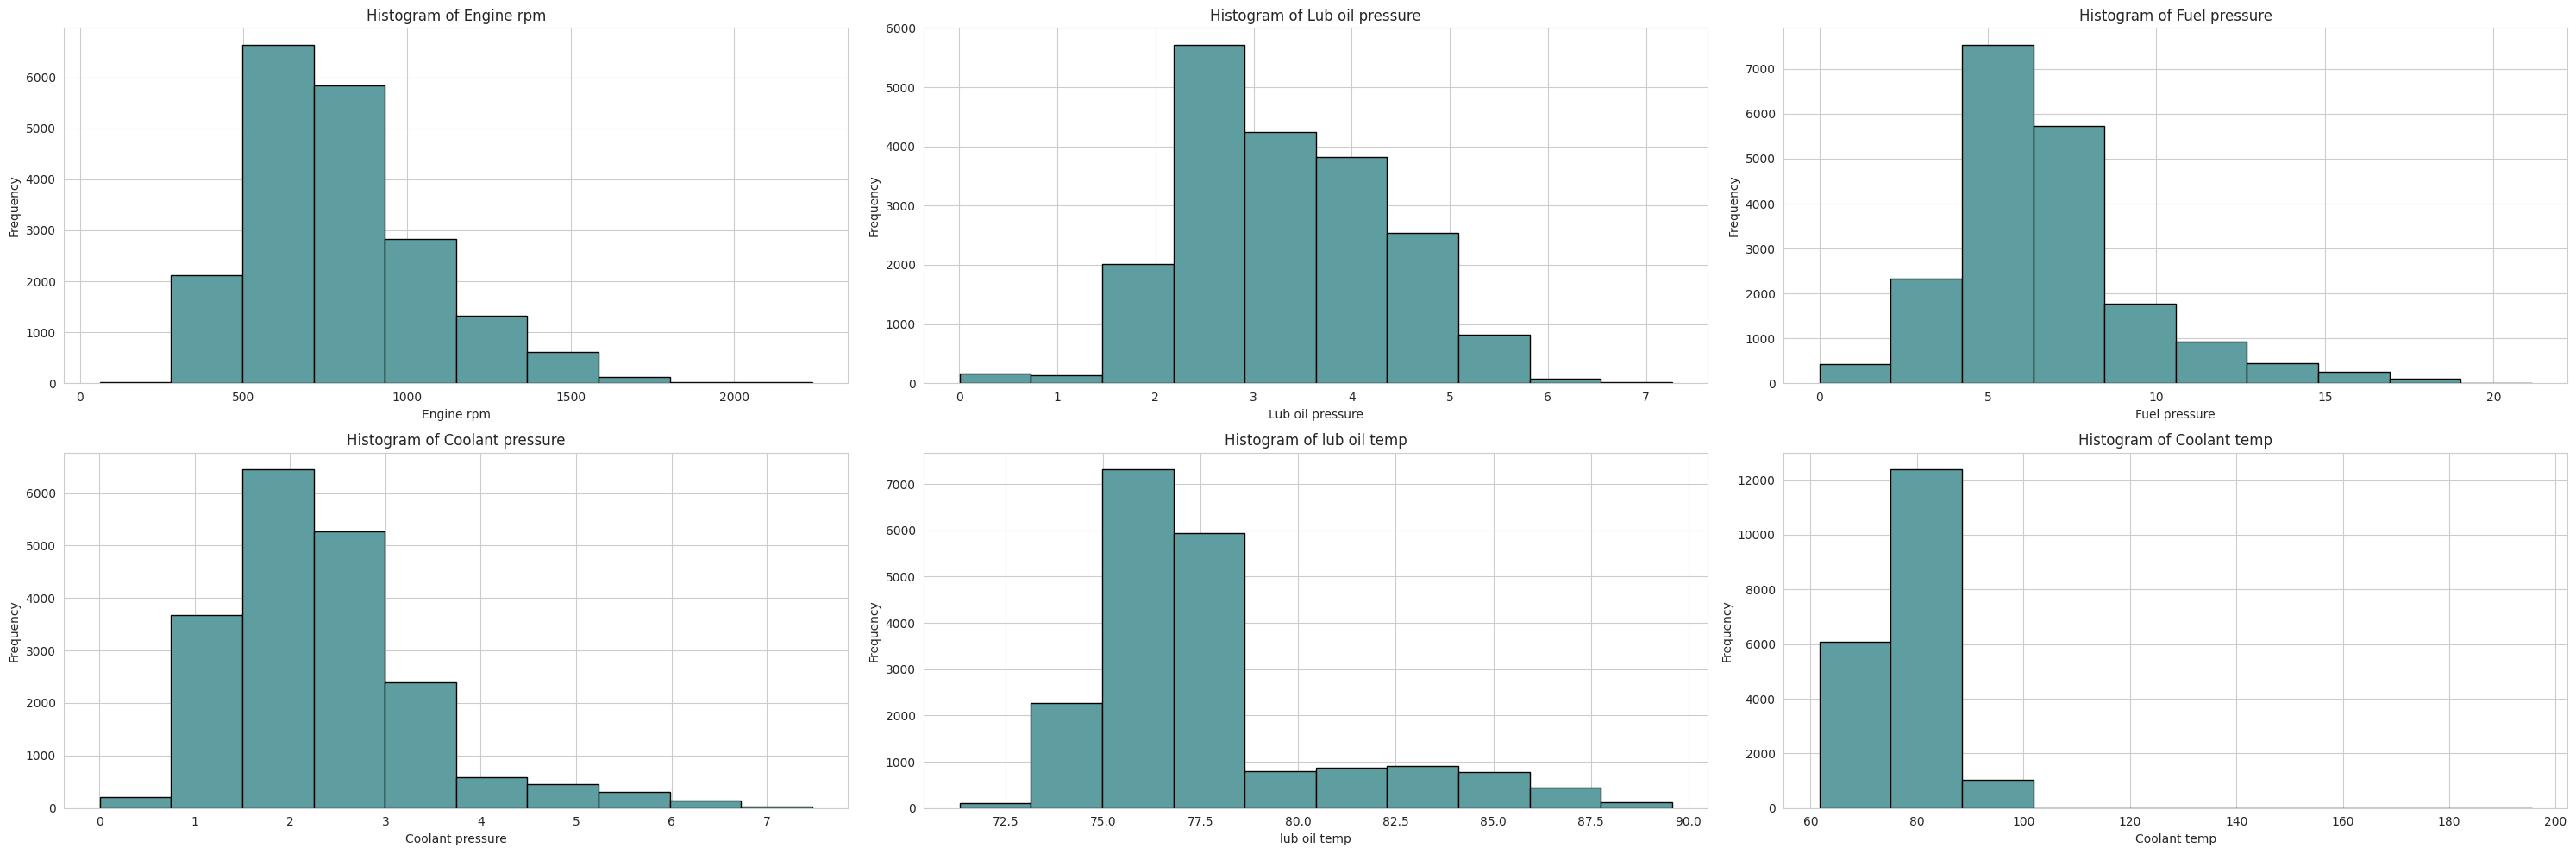

In [31]:
#VISUALISE DISTRIBUTIONS - HISTOGRAMS

# Set up the plot grid
num_columns = len(data.columns)
num_rows = (num_columns +2) // 3

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(num_columns * 5, num_rows * 5))
axes = axes.ravel()  # Flatten axes to 1D for easy iteration

# Plot histogram for each column
for i, column in enumerate(data.columns):
    axes[i].hist(data[column], bins=10, edgecolor='black', color = 'cadetblue')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [4]:
# idenitfying the range values beyond the 95th percentile for at least two features

# Calculate 95th percentiles
oil_temp_95 = data['lub oil temp'].quantile(0.95)
fuel_press_95 = data['Fuel pressure'].quantile(0.95)

# Print oil temperature stats
print("95 percentile oil temperature:", oil_temp_95.round(2))
print("Number of values above 95th percentile for oil temperature:", (data['lub oil temp'] > oil_temp_95).sum())

# Print fuel pressure stats
print("95 percentile Fuel pressure:",fuel_press_95.round(2))
print("Number of values above 95th percentile for fuel pressure:", (data['Fuel pressure'] > fuel_press_95).sum())



95 percentile oil temperature: 84.94
Number of values above 95th percentile for oil temperature: 977
95 percentile Fuel pressure: 12.21
Number of values above 95th percentile for fuel pressure: 977


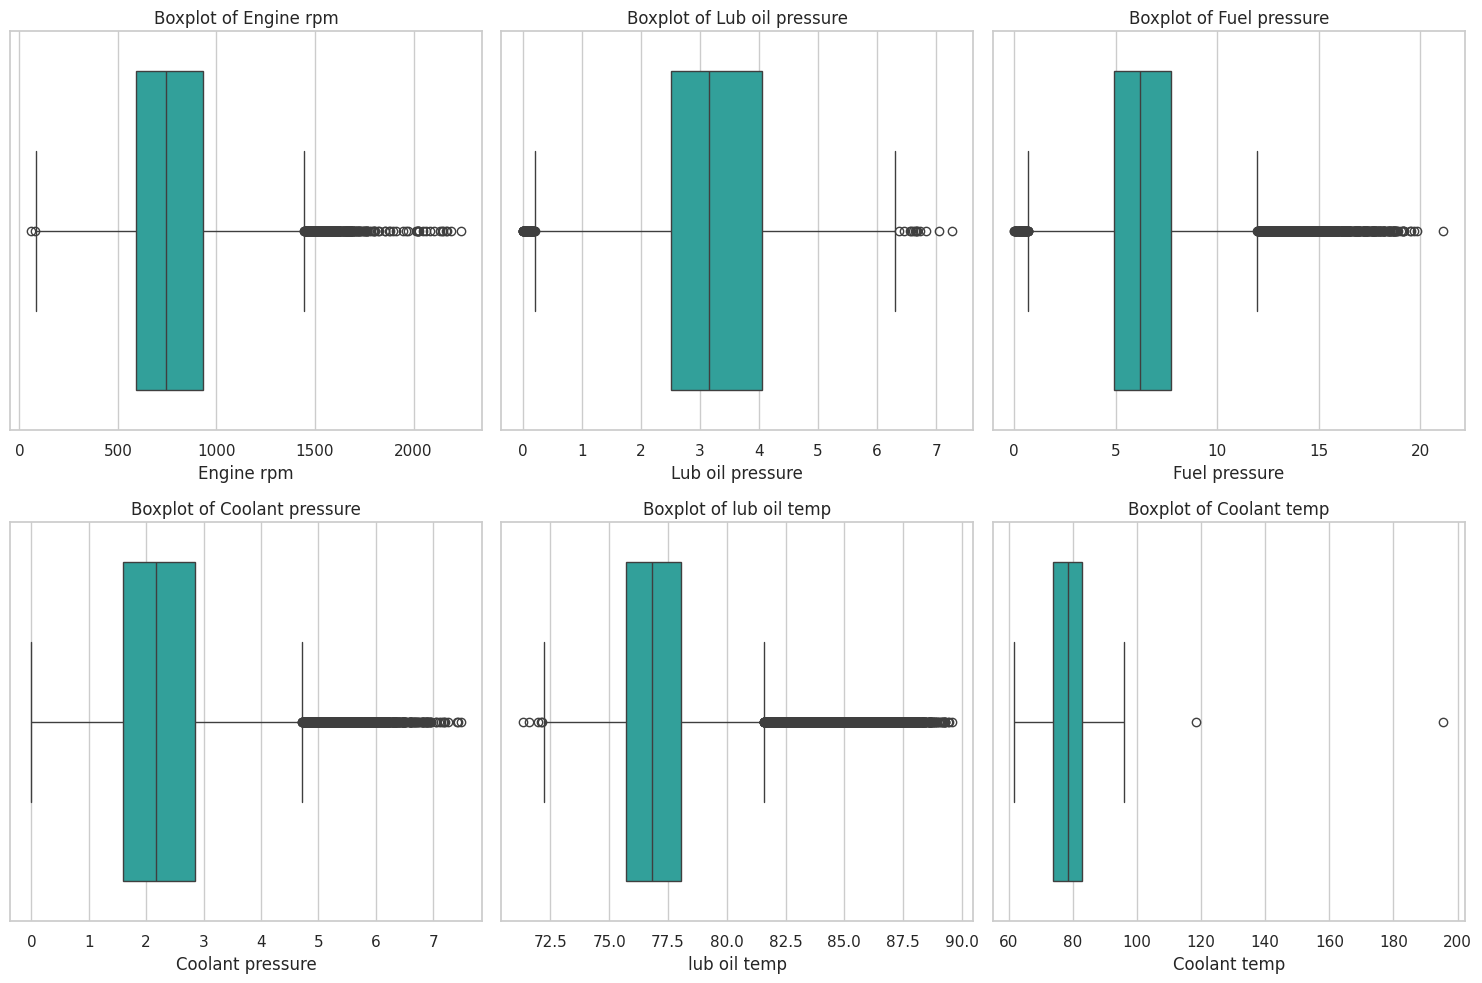

In [35]:
#BOXPLOTS
# Number of columns in the DataFrame
num_cols = len(data.columns)

# Define the grid size: 2 rows, 3 columns
nrows = 2
ncols = 3

# Create subplots with 2 rows and 3 columns (adjust figsize as needed)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

# Flatten axes to make it easy to iterate (necessary if you have multiple rows)
axes = axes.flatten()

sns.set(style="whitegrid")

# Create a boxplot for each column
for i, column in enumerate(data.columns):
    sns.boxplot(x=data[column], ax=axes[i], color='lightseagreen')  # Create boxplot for each column
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel(column)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## **3) Applying IQR method to identify outliers**

In [36]:
# Use the IQR method to identify the outliers.

# Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create binary outlier flags for each column
for column in data.columns:
    data[column + '_outlier'] = ((data[column] < lower_bound[column]) | (data[column] > upper_bound[column])).astype(int)

print(data)

       Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0             682          2.391656       4.617196          2.848982   
1             605          5.466877       6.424361          5.727520   
2             658          3.434232       3.680896          1.678708   
3             749          2.094656       7.120927          1.639670   
4             676          3.538228       5.956472          3.225336   
...           ...               ...            ...               ...   
19530         681          3.598792       7.300853          1.083391   
19531         580          2.243040       5.242489          1.471350   
19532         616          3.310048       3.787693          6.001031   
19533        1163          2.731726       3.703595          2.951684   
19534         695          2.515089       6.355462          2.688567   

       lub oil temp  Coolant temp  Engine rpm_outlier  \
0         76.272417     69.884609                   0   
1         73.222679  

In [37]:
# --- COMBINE OUTLIER FLAGS AND CREATE SUMMARY METRIC ---

# Sum outlier flags across selected columns (indices 6 to 10)
data['Outl_sum'] = data.iloc[:, 6:11].sum(axis=1).astype(int)

# Flag rows with 2 or more outlier features
data['Outl_flag']= data['Outl_sum'].apply(lambda x: 1 if x >= 2 else 0)

# Calculate and print percentage of rows flagged as outliers
outliers_percent = data['Outl_flag'].sum() / len(data) * 100
print("Percentage of outliers: ", outliers_percent.round(2),"%")


Percentage of outliers:  2.16 %


## **4) Apply One-class SVM to detect anomalies**

In [41]:
# ML TO DETECT ANOMALIES - ONE CLASS SVM (useful when anomalies are rare or not defined)
# Import the necessary libraries.
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Mute warnings for clean output
import warnings
warnings.filterwarnings('ignore')



##One-Class SVM parameter calibration:
- 'nu' controls the upper bound on the fraction of outliers (anomalies) and lower bound on the fraction of support vectors.
  Setting nu between 0 and 1 roughly corresponds to the expected proportion of outliers in the data. Higher nu --> more outliers. Good starting point is between 0.01 and 0.1, set as expected share of outliers
- 'gamma' defines the influence of single training examples in the RBF kernel.
  Smaller gamma values imply a smoother decision boundary; larger values make it more sensitive to noise. Higher gamma --> more outliers. good starting point is 1/n features


In this case, nu and gamma were tuned to detect approximately 2-3% of the data as outliers, balancing sensitivity to anomalies while limiting false positives.

In [40]:
# --- SCALE FEATURES USING STANDARD SCALER ---

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_original)

# Convert the scaled data back to a Pandas DataFrame to use .head()
scaled_data_df = pd.DataFrame(scaled_data, columns=data_original.columns)


scaled_data_df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,-0.408212,-0.892819,-0.738304,0.495596,-0.440709,-1.376412
1,-0.695950,2.117332,-0.083759,3.273154,-1.421047,-0.567158
2,-0.497896,0.127697,-1.077426,-0.633625,3.358026,0.044690
3,-0.157842,-1.183534,0.168533,-0.671293,0.005852,0.637913
4,-0.430633,0.229492,-0.253226,0.858747,-0.776966,-1.816491


In [44]:
# --- TEST RobustScaler  ---

from sklearn.preprocessing import RobustScaler

scaler_robust = RobustScaler()
scaled_data_robust = scaler_robust.fit_transform(data_original)

In [42]:
# --- TRAIN ONE-CLASS SVM MODEL ---

model = OneClassSVM(kernel= 'rbf', gamma=0.18, nu=0.02)
model.fit(scaled_data)

# Predict anomalies (-1 means anomaly, 1 means normal)
Y_pred = model.predict(scaled_data)

data['Anomaly SVM'] = Y_pred.reshape(1,-1).T



data.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine rpm_outlier,Lub oil pressure_outlier,Fuel pressure_outlier,Coolant pressure_outlier,lub oil temp_outlier,Coolant temp_outlier,Outl_sum,Outl_flag,Anomaly SVM
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,0,0,0,0,0,0,0,0,1
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,0,0,0,1,0,0,1,0,1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,0,0,0,0,1,0,1,0,1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,0,0,0,0,0,0,0,0,1
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,0,0,0,0,0,0,0,0,1


In [43]:
# --- EXTRACT AND REPORT ONE-CLASS SVM OUTLIERS ---

outliers = data.loc[data['Anomaly SVM']==-1]
outliers_count = len(outliers) / len(data) * 100

print("Share of outliers: ", outliers_count)

Share of outliers:  2.0271307908881493


In [47]:
# SVM on robust scaler
model_robust = OneClassSVM(kernel= 'rbf', gamma=0.18, nu=0.02)
model_robust.fit(scaled_data_robust)

# Predict anomalies (-1 means anomaly)
Y_pred_robust = model_robust.predict(scaled_data_robust)

# Add predictions to dataframe
data['Anomaly SVM Robust'] = Y_pred_robust.reshape(1,-1).T

data.head()


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine rpm_outlier,Lub oil pressure_outlier,Fuel pressure_outlier,Coolant pressure_outlier,lub oil temp_outlier,Coolant temp_outlier,Outl_sum,Outl_flag,Anomaly SVM,Anomaly SVM Robust
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,0,0,0,0,0,0,0,0,1,1
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,0,0,0,1,0,0,1,0,1,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,0,0,0,0,1,0,1,0,1,1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,0,0,0,0,0,0,0,0,1,1
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,0,0,0,0,0,0,0,0,1,1


In [46]:
# share of outliers robust scaler
outliers_rob = data.loc[data['Anomaly SVM Robust']==-1]
outliers_rob_count = len(outliers_rob) / len(data) * 100

print("Share of outliers with robust scaler: ", outliers_rob_count)

Share of outliers with robust scaler:  2.011773739442027


Robust scaler seems a bit less sensitive

## **5) Applying PCA to reduce the number of features to visualise the data for One-class SVM**

In [48]:
# --- PCA SETUP FOR DATA VISUALISATION ---

# Import the required libraries and functions.
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

# Scale the original data for PCA
scaler = StandardScaler()
scaled_data_PCA = scaler.fit_transform(data_original)

# Convert the scaled data back to a Pandas DataFrame to use .head()
scaled_data_PCA = pd.DataFrame(scaled_data_PCA, columns=data_original.columns)


scaled_data_PCA.head()


,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,-0.408212,-0.892819,-0.738304,0.495596,-0.440709,-1.376412
1,-0.695950,2.117332,-0.083759,3.273154,-1.421047,-0.567158
2,-0.497896,0.127697,-1.077426,-0.633625,3.358026,0.044690
3,-0.157842,-1.183534,0.168533,-0.671293,0.005852,0.637913
4,-0.430633,0.229492,-0.253226,0.858747,-0.776966,-1.816491


In [18]:
# --- APPLY PCA TO REDUCE DIMENSIONS TO 2 COMPONENTS ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_data_PCA)

In [19]:
# Compare the shape of the normalised and PCA data.
print("Normalised data: ", scaled_data_PCA.shape)
print("PCA data for visualisation: ", X_pca.shape)

Normalised data:  (19535, 6)
PCA data for visualisation:  (19535, 2)


In [49]:
# Create a DataFrame from the PCA components
data_PCA = pd.DataFrame(X_pca, columns=['PC1','PC2'])

data_PCA['Anomaly PCA']= Y_pred
data_PCA.head()


,PC1,PC2,Anomaly PCA
0,-0.557362,-0.906512,1
1,-2.177170,-1.201538,1
2,2.051806,1.039581,1
3,0.744375,-0.501140,1
4,-1.629821,-0.473906,1


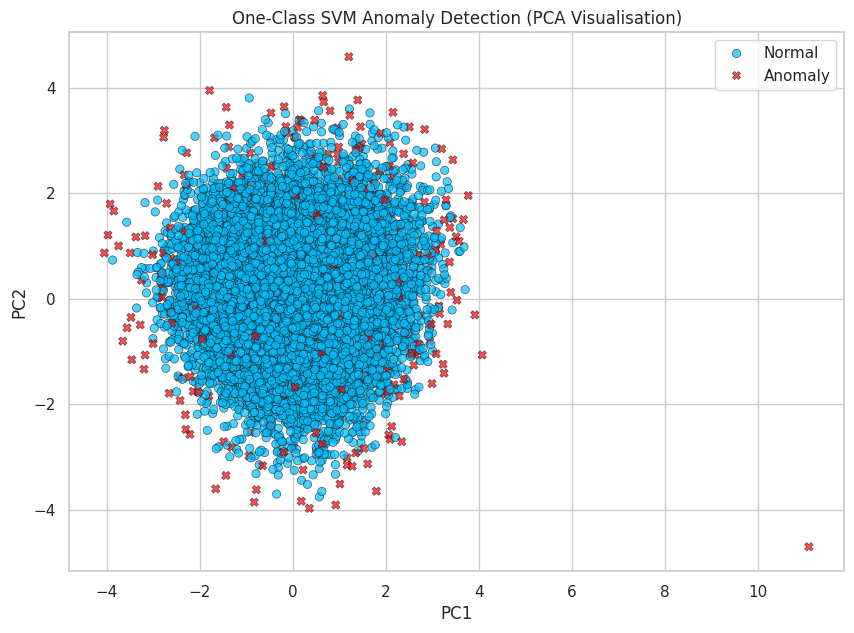

In [51]:
# Create a combined DataFrame for visualisation
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['Anomaly'] = np.where(Y_pred == -1, 'Anomaly', 'Normal')

# Plot using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df,
    x='PC1', y='PC2',
    hue='Anomaly',
    style='Anomaly',
    palette={'Normal': 'deepskyblue', 'Anomaly': 'red'},
    markers={'Normal': 'o', 'Anomaly': 'X'},
    alpha=0.7,
    edgecolor='k'
)
plt.title('One-Class SVM Anomaly Detection (PCA Visualisation)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## **6) Running Isolation Forest algorithm**

In [52]:
# ISOLATION FOREST
# Import the necessary libraries.
from sklearn.ensemble import IsolationForest


# Mute warnings.
warnings.filterwarnings('ignore')



In [53]:
# Initialize and fit Isolation Forest
# n estimators = number of trees generated, more trees improve model performance but heavy on computation and overfitting likely
# contamination is the expected share of anomalies, normally set to auto
# we then allow the algorithm to learn by feeding it X values
iso_forest = IsolationForest(n_estimators=100, contamination=0.025, random_state=42) #contamination is the expected share of outliers
iso_forest.fit(data_original)

IsolationForest(contamination=0.025, random_state=42)

In [54]:
scores_pred = iso_forest.decision_function(data_original)
print(scores_pred)
# higher values = normal points, low or negative = anomalies

[ 0.14559083 -0.01069846  0.0407479  ...  0.07313602  0.14229338
  0.15473378]


In [56]:
# Predict the anomalies (1 for not anomaly, -1 for anomaly).
y_pred = iso_forest.predict(data_original)

# View output.
y_pred

array([ 1, -1,  1, ...,  1,  1,  1])

In [57]:
# Add Isolation Forest anomaly predictions to the working DataFrame
# (-1 indicates anomaly, 1 indicates normal)
data['anomaly IsoForest'] = y_pred

# View output.
data.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine rpm_outlier,Lub oil pressure_outlier,Fuel pressure_outlier,Coolant pressure_outlier,lub oil temp_outlier,Coolant temp_outlier,Outl_sum,Outl_flag,Anomaly SVM,Anomaly SVM Robust,anomaly IsoForest
0,682,2.391656,4.617196,2.848982,76.272417,69.884609,0,0,0,0,0,0,0,0,1,1,1
1,605,5.466877,6.424361,5.727520,73.222679,74.907314,0,0,0,1,0,0,1,0,1,-1,-1
2,658,3.434232,3.680896,1.678708,88.089916,78.704806,0,0,0,0,1,0,1,0,1,1,1
3,749,2.094656,7.120927,1.639670,77.661625,82.386700,0,0,0,0,0,0,0,0,1,1,1
4,676,3.538228,5.956472,3.225336,75.226352,67.153220,0,0,0,0,0,0,0,0,1,1,1


In [61]:
#DOUBLE CHECKING ISOLATION FOREST RESULTS
outliers_iso = data.loc[data['anomaly IsoForest']==-1]
outliers_percent = (len(outliers_iso) / len(data)) * 100

print(f"Share of outliers detected by Isolation Forest: {outliers_percent:.2f}%")

Share of outliers detected by Isolation Forest: 2.50%


## **7) PCA also to Isolation Forest for visualisation**

In [62]:
# PCA to ISOLATION FOREST
data_PCA_IF = pd.DataFrame(X_pca, columns=['PC1','PC2'])

data_PCA_IF['Anomaly_IF']= y_pred
data_PCA_IF.head()

,PC1,PC2,Anomaly_IF
0,-0.557362,-0.906512,1
1,-2.177170,-1.201538,-1
2,2.051806,1.039581,1
3,0.744375,-0.501140,1
4,-1.629821,-0.473906,1


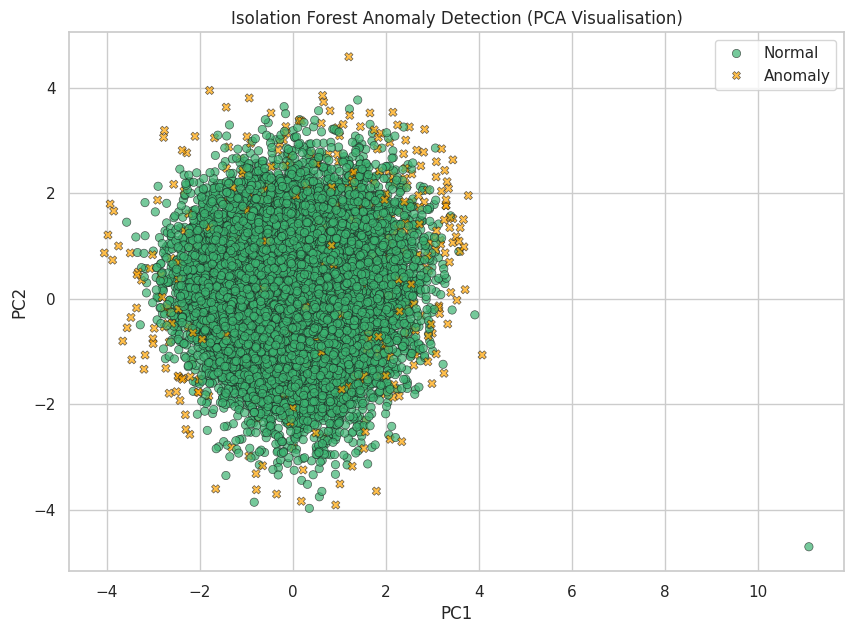

In [63]:
# Create a combined DataFrame for visualization
plot_df_if = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df_if['Anomaly'] = np.where(y_pred == -1, 'Anomaly', 'Normal')

# Plot using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=plot_df_if,
    x='PC1', y='PC2',
    hue='Anomaly',
    style='Anomaly',
    palette={'Normal': 'mediumseagreen', 'Anomaly': 'orange'},
    markers={'Normal': 'o', 'Anomaly': 'X'},
    alpha=0.7,
    edgecolor='k'
)
plt.title('Isolation Forest Anomaly Detection (PCA Visualisation)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## **Reflections**

All three anomaly detection methods applied (IQR, Isolation Forest, and One-Class SVM) performed well and produced fairly consistent results.

<br>

The **IQR method** is possibly the most straightforward and easy to understand, but if, like in this case, we are presented with multiple features, it might require expert knowledge of the field to understand which features interact and how. For example, a combination of high RPM and high water temperature might be normal and should not be flagged as anomalous. Collaborating with a ship engineer familiar with these variables is essential to accurately interpret such interactions.

<br>

**Isolation forest** is also easy to implement, especially when the expected proportion of outliers is known. It provides a robust, automated approach without needing extensive feature engineering.

<br>

In my view, the **One-Class SVM** is the best tool among those applied. As it’s a machine learning model, it minimises the risk of human error (typos or incongruent assumptions) and it’s also very flexible as we have two parameters to adjust to aim for the best fit.


As my domain knowledge of ship engine behaviour is limited, in order to recommend which variables are more critical and how they interact, I would recommend involving subject matter experts to guide the creation of derived features that capture meaningful relationships— for example, the ratio of RPM to coolant temperature. Such engineered features could enhance the analysis by highlighting critical conditions, like high RPM occurring simultaneously with low coolant temperature, which may indicate greater risk of malfunction.


### Reference:
Devabrat, M., 2022. Predictive Maintenance on Ship's Main Engine using AI. Available at: https://dx.doi.org/10.21227/g3za-v415. [Accessed 5 March 2024]